In [1]:
import numpy as np
from astropy.io import fits
from numpy.lib.function_base import _calculate_shapes
import pandas as pd
import os
import math
from matplotlib import pyplot as plt

Mount google drive and set the path where our data is stored. We can also use local files but they are slower to upload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dir_path = "drive/MyDrive/Colab Notebooks/SKAData/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get the fits file from the drive and extract the image

In [24]:
fits_img = fits.open(dir_path + "SKAMid_B1_8h_v3.fits")
print(fits_img.info())
fits_img = fits_img[0].data[0,0,:,:]
fits_img = fits_img[16350:,16350:]

Filename: drive/MyDrive/Colab Notebooks/SKAData/SKAMid_B1_8h_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     118   (32768, 32768, 1, 1)   float32   
None


Parameter settings:

*   since, when using the entire image the RAM of the system fills easily, we can use the image_size variable to work only on a portion of the image
*   cutout_size is the size of the squares in which the image is divided


In [4]:
cutout_size = 218
#image_size = 32700
#image_size = 15260
image_size = 4360
cutouts_per_row = image_size//cutout_size

Divide the image

In [25]:
cutouts = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    cutouts[i*cutouts_per_row+j] = fits_img[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del fits_img

**Data Normalization**

In [26]:
for i in range(len(cutouts)):
  f = cutouts[i].flatten()
  avg = np.mean(f)
  std = np.std(f)
  cutouts[i] = (cutouts[i] - avg) / std

Upload the already filtered training set from the drive

In [9]:
FilteredTrainingSet=pd.read_csv(dir_path + "new_filtered_training_set.csv",)
#FilteredTrainingSet=pd.read_csv(dir_path + "TrainingSet_B1_v2.txt",skiprows=17,delimiter='\s+')
FilteredTrainingSet=FilteredTrainingSet[FilteredTrainingSet.columns[0:15]]
FilteredTrainingSet.columns=['ID','RA (core)','DEC (core)','RA (centroid)','DEC (centroid)','FLUX','Core frac','BMAJ','BMIN','PA','SIZE','CLASS','SELECTION','x','y']
FilteredTrainingSet['x']=FilteredTrainingSet['x'].astype(int)
FilteredTrainingSet['y']=FilteredTrainingSet['y'].astype(int)
FilteredTrainingSet['x']=FilteredTrainingSet['x']-16350
FilteredTrainingSet['y']=FilteredTrainingSet['y']-16350
FilteredTrainingSet = FilteredTrainingSet.set_index('ID')
print(np.min(FilteredTrainingSet['y']),np.max(FilteredTrainingSet['y']),np.min(FilteredTrainingSet['x']),np.max(FilteredTrainingSet['x']))

382 3570 33 3520


Generate images from the training set where each dot corresponds to a source

In [10]:
data=np.zeros((image_size,image_size), dtype=np.uint8 )
for i in range(0,len(FilteredTrainingSet)):
	    data[int(FilteredTrainingSet['y'].iloc[i]),int(FilteredTrainingSet['x'].iloc[i])] = 1

Divide the data generated images

In [11]:
data_array = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    data_array[i*cutouts_per_row+j] = data[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del data

In [12]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import regularizers

Divide the dataset in train,validation and test sets

In [13]:
train_x, test_x, train_y, test_y = train_test_split(cutouts, data_array, test_size=0.25, random_state=42,shuffle=True)
del cutouts
del data_array
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42,shuffle=True)

Define custom layer for REFLECT padding

In [14]:
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow 

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tensorflow.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'padding' : self.padding
        })
        return config

Define the model

In [15]:
input_layer = Input(shape=(cutout_size, cutout_size, 1))
x = ReflectionPadding2D(padding = (3,3))(input_layer)
x = Conv2D(16, (7, 7), strides=1, activation='relu')(x)
x = ReflectionPadding2D(padding = (2,2))(x)
x = Conv2D(32, (5, 5), strides=1, activation='relu')(x)
x = ReflectionPadding2D(padding = (1,1))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
output_layer = Dense(1,activation='sigmoid')(x)

myCNN = Model(input_layer,output_layer)
adadelta = optimizers.Adadelta(learning_rate=1.0, decay=0.0, rho=0.99)
myCNN.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

print(myCNN.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 218, 218, 1)]     0         
_________________________________________________________________
reflection_padding2d (Reflec (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 16)      800       
_________________________________________________________________
reflection_padding2d_1 (Refl (None, 222, 222, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 218, 218, 32)      12832     
_________________________________________________________________
reflection_padding2d_2 (Refl (None, 220, 220, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 64)      18496 

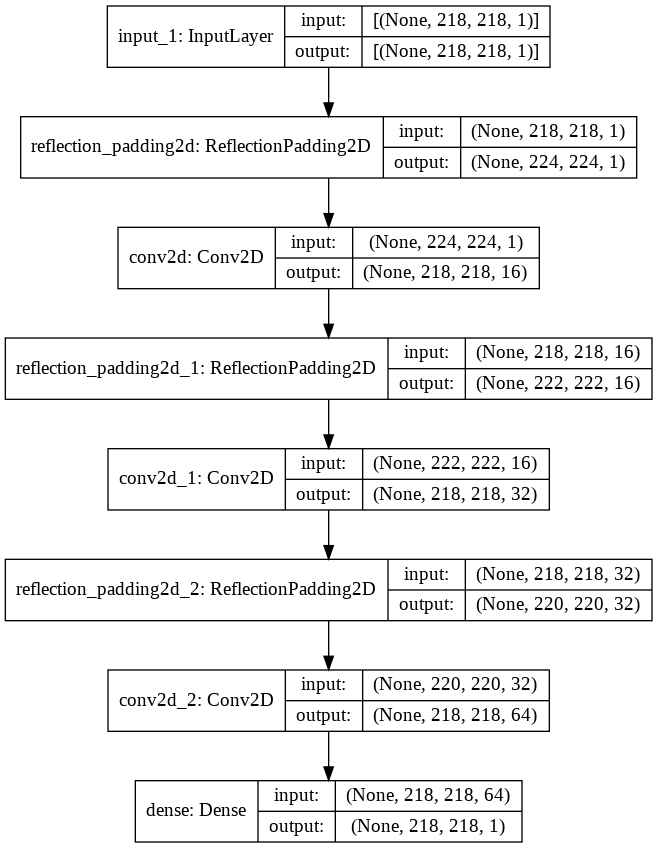

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(myCNN,show_shapes=True)

Training of our model

In [17]:
batch_size = 32

In [18]:
base_history = myCNN.fit(train_x, train_y, epochs=10, batch_size=batch_size, shuffle=True, validation_data=(val_x, val_y), verbose=1, callbacks=[es, cp])

Epoch 1/10
8/8 [==============================] - 67s 8s/step - loss: 0.2007 - accuracy: 0.9886 - val_loss: 0.0298 - val_accuracy: 0.9988

Epoch 00001: val_loss improved from inf to 0.02984, saving model to best_model.hdf5
Epoch 2/10
8/8 [==============================] - 65s 8s/step - loss: 0.0185 - accuracy: 0.9987 - val_loss: 0.0190 - val_accuracy: 0.9988

Epoch 00002: val_loss improved from 0.02984 to 0.01900, saving model to best_model.hdf5
Epoch 3/10
8/8 [==============================] - 65s 8s/step - loss: 0.0139 - accuracy: 0.9987 - val_loss: 0.0150 - val_accuracy: 0.9988

Epoch 00003: val_loss improved from 0.01900 to 0.01498, saving model to best_model.hdf5
Epoch 4/10
8/8 [==============================] - 66s 8s/step - loss: 0.0120 - accuracy: 0.9987 - val_loss: 0.0131 - val_accuracy: 0.9988

Epoch 00004: val_loss improved from 0.01498 to 0.01306, saving model to best_model.hdf5
Epoch 5/10
8/8 [==============================] - 65s 8s/step - loss: 0.0110 - accuracy: 0.9987 

In [22]:
print(base_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

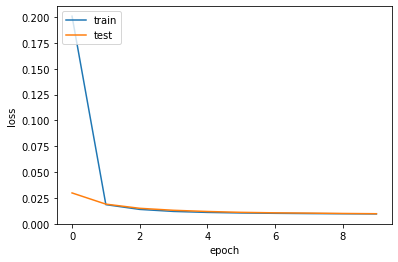

In [20]:
plot_history(base_history,['loss','val_loss'])

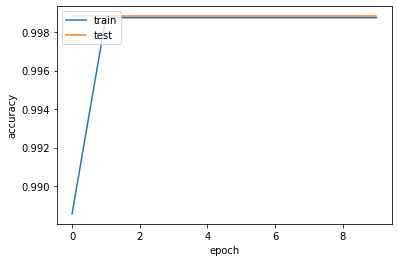

In [21]:
plot_history(base_history,['accuracy','val_accuracy'])

**Performance evaluation**

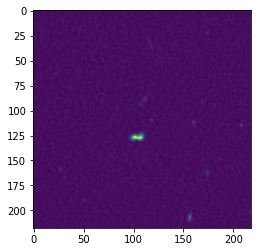

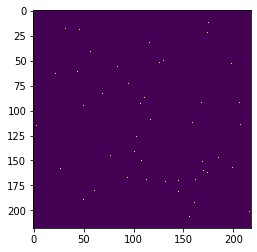

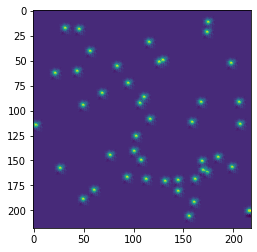

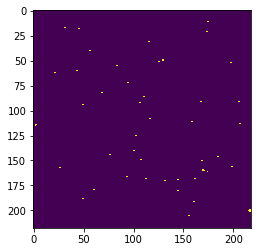

In [68]:
plt.imshow(test_x[90])
plt.show()

plt.imshow(test_y[90])
plt.show()

t = myCNN.predict(test_y[90:91])

f = t[0,:,:,0].flatten()
avg = np.mean(f)
std = np.std(f)
max = np.max(f)
t = (t[0,:,:,0] / max)

plt.imshow(t)
plt.show()

a = t
a[a<0.9] = 0
a[a>=0.9] = 1

plt.imshow(a)
plt.show()


**Display Filters**

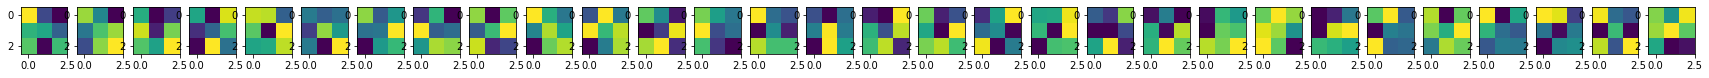

In [52]:
from matplotlib.pyplot import figure

# retrieve weights from the second hidden layer
filters, biases = myCNN.layers[6].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = np.shape(filters)[-1], 1

fig = plt.figure(figsize=(30,15))
n_filters = 30
for i in range(n_filters):
  f = filters[:, :, 0, i]
  fig.add_subplot(1,n_filters,ix)
  # plot filter channel in grayscale
  plt.imshow(f[:, :])
  ix += 1
# show the figure
plt.show()

**Display Feature Maps**

In [49]:
def show_feature_maps(model,img, layer_num):
  
  feature_maps = model.predict(img)
  fig = plt.figure(figsize=(30,9))

  f1 = feature_maps[layer_num][0,:,:]
  num_features = np.shape(f1)[-1]

  for i in range(num_features):
    fig.add_subplot(num_features//8,8,i+1)
    plt.imshow(f1[:,:,i])

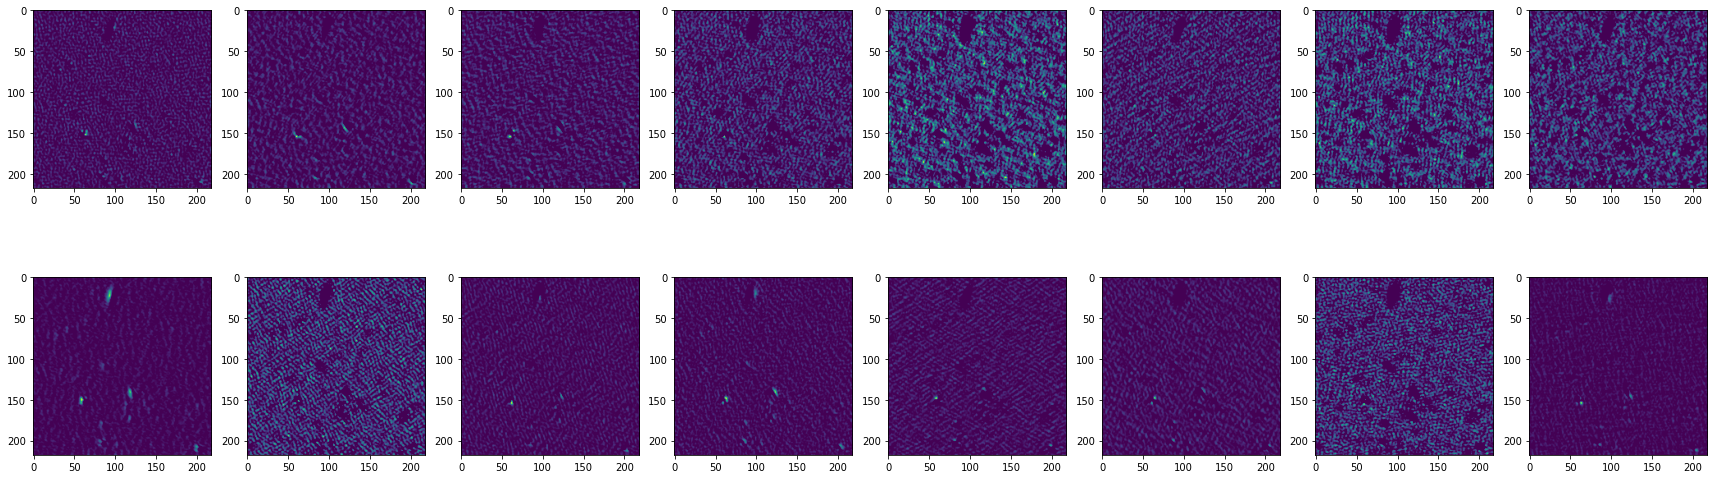

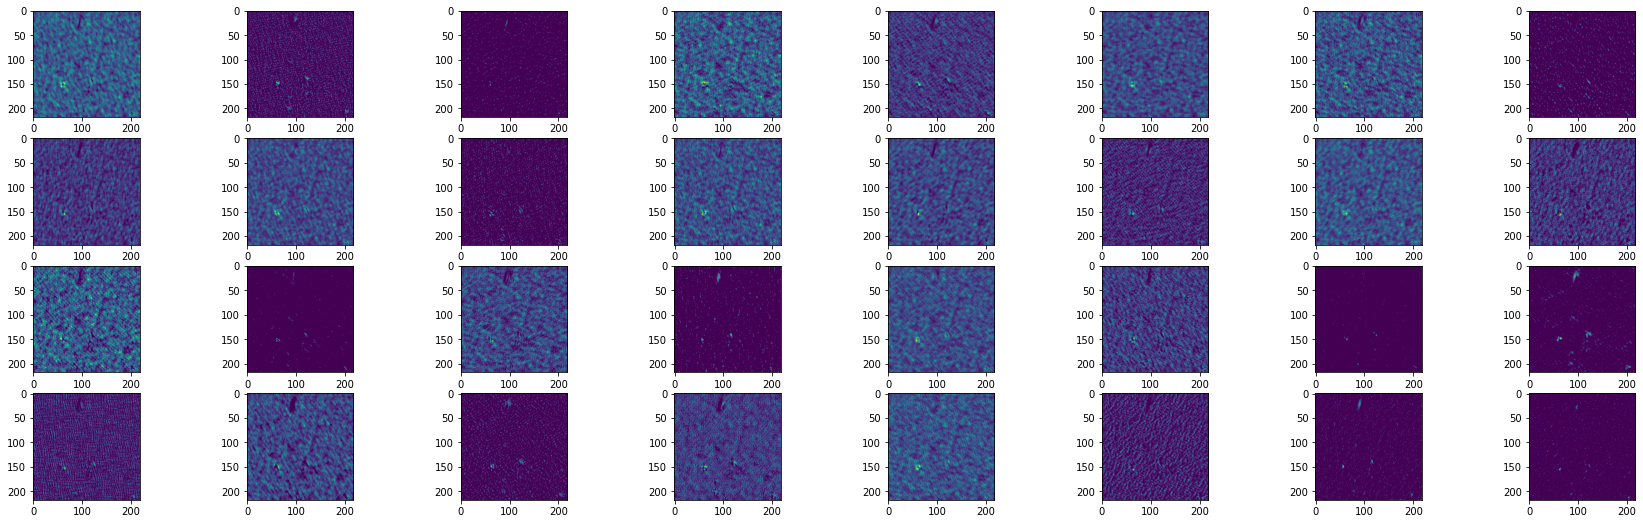

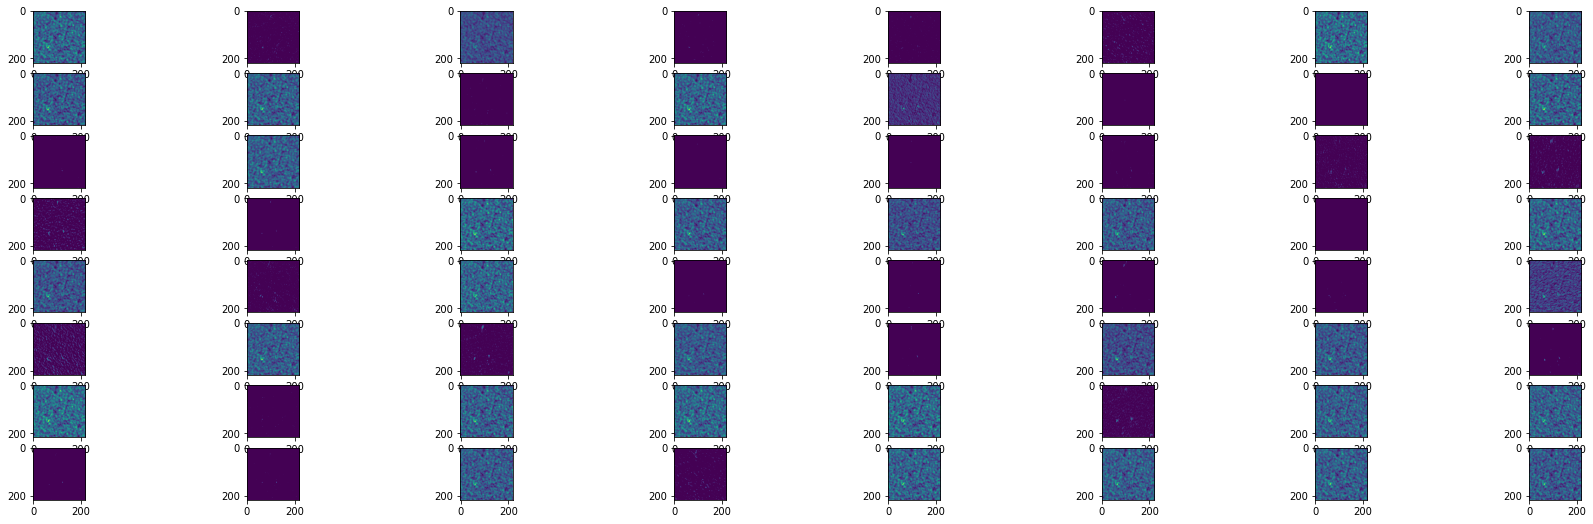

In [54]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

ixs = [2, 4, 6]
outputs = [myCNN.layers[i].output for i in ixs]
model = Model(inputs=myCNN.inputs, outputs=outputs)

# load the image with the required shape
img = cutouts[3*cutouts_per_row]

# convert the image to an array
img = img_to_array(img)

# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

for i in range(len(ixs)):
  show_feature_maps(model,img,i)